<a href="https://colab.research.google.com/github/angielaura/Exploring-Common-Risk-Patterns-and-Future-Susceptibility-to-Diabetes-Using-IBM-Granite/blob/main/IBM_Granite_SDI_Data_S2_Angie_Laura_Irene.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring Common Risk Patterns and Future Susceptibility to Diabetes Using IBM Granite

## Installing the Dependencies and Dataset

### Dependencies

In [1]:
# Install Langchain core library to build the workflow with LLM
!pip install -U langchain

# Install Langchain Community for model integration like Replicate
!pip install -U langchain-community

# Install Langchain Experimental for features like Pandas DataFrame Agent
!pip install -U langchain-experimental

# Install Replicate to access the Granite Model (or any other model)
!pip install -U replicate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.9/438.9 kB 16.3 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.65
    Uninstalling langchain-core-0.3.65:
      Successfully uninstalled langchain-core-0.3.65
  Attempting uninstall: langchain
    Found existing installation: langchain 0.3.25
    Uninstalling langchain-0.3.25:
      Successfully uninstalled langchain-0.3.25
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.2/209.2 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 2.0 MB/s eta 0:00:00


###Libraries

In [2]:
import pandas as pd # Use pandas to read the tabular data
import os # To set the environment variable
from google.colab import files, userdata # Import the files from local device and userdata to get the API token in Colab
from langchain_community.llms import Replicate # Import class Replicate to call the Granite Model
from langchain_experimental.agents.agent_toolkits.pandas.base import create_pandas_dataframe_agent # Langchain experimental agent toolkit for pandas

### Dataset

In [3]:
uploaded = files.upload()

Saving diabetes_prediction_dataset.csv to diabetes_prediction_dataset.csv


## Preprocessing

###Read the data

In [4]:
df = pd.read_csv('diabetes_prediction_dataset.csv') # Read CSV
df.head(5) # Preview the top 5 rows

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


### Check null values, remove if any

In [5]:
df.isnull().sum() # Check null value

,0
gender,0
age,0
hypertension,0
heart_disease,0
smoking_history,0
bmi,0
HbA1c_level,0
blood_glucose_level,0
diabetes,0


###Data types

In [6]:
df.dtypes # Check the data types

,0
gender,object
age,float64
hypertension,int64
heart_disease,int64
smoking_history,object
bmi,float64
HbA1c_level,float64
blood_glucose_level,int64
diabetes,int64


In [7]:
df['age'] = df['age'].astype('int') # Transform the data types into integer

###Turn the tabular data into text format

Check the unique categorical value

In [8]:
df['smoking_history'].unique() # Check the unique value of 'smoking_history' for the function

array(['never', 'No Info', 'current', 'former', 'ever', 'not current'],
      dtype=object)

The function

In [9]:
def row_to_text(row) :
    gender = row['gender']
    age = row['age']
    bmi = row['bmi']
    hba1c = row['HbA1c_level']
    glucose = row['blood_glucose_level']

    # Interprate the binary features
    hypertension = "has hypertension" if row['hypertension'] == 1 else "does not have hypertension"
    heart_disease = "has a history of heart disease" if row['heart_disease'] == 1 else "has no history of heart disease"

    # Interprate the smoking features
    smoking_map = {
        'never': 'has never smoked',
        'No Info': 'has unknown smoking history',
        'former': 'is a former smoker',
        'current': 'is currently smoking',
        'ever': 'has smoked before',
        'not current': 'is not currently smoking'
    }

    smoking = smoking_map.get(row['smoking_history'], 'has unknown smoking history')

    return (
        f"A {age}-year-old {gender} with a BMI of {bmi:.1f}, "
        f"HbA1c level of {hba1c:.1f}, and blood glucose level of {glucose} mg/dL. "
        f"The person {hypertension}, {heart_disease}, and {smoking}."
    )

Split them into groups

In [10]:
df_diabetes = df[df['diabetes'] == 1]
df_nondiabetes = df[df['diabetes'] == 0]

Apply the function

In [11]:
df_diabetes.loc[:, 'descriptive_text'] = df_diabetes.apply(row_to_text, axis=1)
df_nondiabetes.loc[:, 'descriptive_text'] = df_nondiabetes.apply(row_to_text, axis=1)

/tmp/ipython-input-11-1308465048.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_diabetes.loc[:, 'descriptive_text'] = df_diabetes.apply(row_to_text, axis=1)
/tmp/ipython-input-11-1308465048.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nondiabetes.loc[:, 'descriptive_text'] = df_nondiabetes.apply(row_to_text, axis=1)


Check the table

In [12]:
df_diabetes.head(5)

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes,descriptive_text
6,Female,44,0,0,never,19.31,6.5,200,1,"A 44-year-old Female with a BMI of 19.3, HbA1c..."
26,Male,67,0,1,not current,27.32,6.5,200,1,"A 67-year-old Male with a BMI of 27.3, HbA1c l..."
38,Male,50,1,0,current,27.32,5.7,260,1,"A 50-year-old Male with a BMI of 27.3, HbA1c l..."
40,Male,73,0,0,former,25.91,9.0,160,1,"A 73-year-old Male with a BMI of 25.9, HbA1c l..."
53,Female,53,0,0,former,27.32,7.0,159,1,"A 53-year-old Female with a BMI of 27.3, HbA1c..."


In [13]:
df_nondiabetes.head(5)

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes,descriptive_text
0,Female,80,0,1,never,25.19,6.6,140,0,"A 80-year-old Female with a BMI of 25.2, HbA1c..."
1,Female,54,0,0,No Info,27.32,6.6,80,0,"A 54-year-old Female with a BMI of 27.3, HbA1c..."
2,Male,28,0,0,never,27.32,5.7,158,0,"A 28-year-old Male with a BMI of 27.3, HbA1c l..."
3,Female,36,0,0,current,23.45,5.0,155,0,"A 36-year-old Female with a BMI of 23.4, HbA1c..."
4,Male,76,1,1,current,20.14,4.8,155,0,"A 76-year-old Male with a BMI of 20.1, HbA1c l..."


Turn the tabular format into chunk of texts

In [14]:
diabetes_profile = '\n'.join(df_diabetes['descriptive_text'].tolist())
nondiabetes_profile = '\n'.join(df_nondiabetes['descriptive_text'].tolist())

Checking the length

In [15]:
print(len(diabetes_profile))  # Check the length, Granite can only handle 4000 Tokens
print(len(nondiabetes_profile))

1639210
17973641


Take samples

In [16]:
sample_diabetes = df_diabetes.sample(n=50, random_state=7)  # Take 50 random diabetic patients
diabetes_sample = '\n'.join(sample_diabetes['descriptive_text'].tolist())

sample_nondiabetes = df_nondiabetes.sample(n=50, random_state=7) # Take another 50 random patients who has no diabetes
nondiabetes_sample = '\n'.join(sample_nondiabetes['descriptive_text'].tolist())

Samples for visualization

In [17]:
# Combining the samples
sample_combined = pd.concat([sample_diabetes, sample_nondiabetes])

# Drop descriptive text
sample_combined_clean = sample_combined.drop(columns=['descriptive_text'])

# Check numeric columns for the agents to process
numeric_columns = sample_combined_clean.select_dtypes(include='number').columns
sample_combined_clean = sample_combined_clean[numeric_columns]

## Model Preparation

###Setup Replicate API token

In [18]:
# Get the token from secrets
api_token = userdata.get("api_token")

# Put token to env variable, so the replicate library can found it automatically
os.environ["REPLICATE_API_TOKEN"] = api_token

###Setup Granite Model and parameters

Defining Parameters

In [19]:
parameters = {
  "top_k": 5,  # Took 5 tokens with the highest probabilities
  "top_p": 1.0,  # Top-p sampling (nucleus sampling)
  "max_tokens": 4096,  # Maximum token that can be generated by the model
  "min_tokens": 0,  # Minimum token that can be generated
  "random_seed": 7,  # Seed for replicated output
  "repetition_penalty": 1.0,  # Penalti to avoid token repetition
  "temperature": 0.7,  # Controlling creativity (0 : determiniistic, 1 : more creative)
  "stopping_criteria": "length (256 tokens)",  # Criteria to stop the output
  "stopping_sequence": None  # Stop-token used (none)
}

Defining the model

In [20]:
llm = Replicate(
  model = "ibm-granite/granite-3.3-8b-instruct",  # Using this Granite model
  model_kwargs = parameters  # Put the parameters into the model to set the output
)

## Execution

Prompts

In [21]:
# To find out which characteristics that may contribute to diabetes
prompt_diabetes = f"""
Below are anonymized profiles of individuals diagnosed with diabetes.
Your task is to identify and summarize the most common characteristics or risk factors contributing to diabetes.
Focus on detecting clear patterns related to:
- Age
- Body Mass Index (BMI)
- HbA1c level
- Blood glucose level
- Smoking history
- Hypertension and heart disease history

Summarize the key findings in a structured and concise manner.

{diabetes_sample}
"""

# To find out which individuals that has the risk of developing diabetes
prompt_risk = f"""
Below are anonymized profiles of individuals who do not currently have diabetes.
Analyze and summarize the characteristics that indicate they might be at higher risk of developing diabetes in the future.
Focus on detecting shared patterns and risk indicators, including:
- Age
- BMI
- HbA1c
- Blood glucose
- Smoking history
- Health issues (e.g., hypertension or cardiovascular symptoms)

Do not evaluate individuals one by one. Focus on general trends and explain the reasoning.

{nondiabetes_sample}
"""



### Granite to gain insights

In [22]:
response_diabetes = llm.invoke(prompt_diabetes)
print(response_diabetes)

### Key Findings Summary on Diabetes Risk Factors

Upon reviewing the anonymized profiles of individuals diagnosed with diabetes, the following patterns and risk factors emerge:

#### Age:
- The majority of the cases (80-year-olds) indicate that advanced age is a significant risk factor for diabetes diagnosis.

#### Body Mass Index (BMI):
- High BMI is prevalent among these profiles, with BMIs ranging from 21.0 to 54.6. Notably, a substantial number of cases (11 out of 35) have BMIs classified as obese (BMI ≥ 30).

#### HbA1c Levels:
- HbA1c levels vary widely, ranging from 5.7 to 9.0, with a cluster of higher readings (above 8.0) in a few cases, suggesting poorer glycemic control.

#### Blood Glucose Levels:
- Blood glucose levels also show variability, ranging from 130 to 300 mg/dL. Higher readings (above 250 mg/dL) are observed in several profiles, indicating poor management or newly diagnosed cases.

#### Smoking History:
- Smoking history is inconsistently reported, but there's a 

In [23]:
response_risk = llm.invoke(prompt_risk)
print(response_risk)

Analyzing the provided profiles, several patterns and risk indicators for developing diabetes in the future can be identified:

1. **Age**: Individuals aged 40 and above are more prevalent in these profiles. Aging is associated with an increased risk of developing type 2 diabetes due to physiological changes in glucose metabolism and insulin resistance.

2. **BMI**: Higher BMI values (27 and above) appear more frequently among these individuals, indicating overweight or obesity, a significant risk factor for diabetes. Notably, some profiles show very high BMI values (e.g., 34.2, 48.7), which substantially elevate diabetes risk.

3. **HbA1c and Blood Glucose Levels**: Elevated HbA1c levels (above 5.7) and blood glucose levels, particularly those above 140 mg/dL, suggest impaired glucose tolerance or pre-diabetic conditions. Even though most individuals currently do not have diabetes, these values indicate potential future risk.

4. **Smoking History**: Although not as prevalent, smoking

###Manual Visualization

Import visualizations library

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Set the colors and variables

In [25]:
colors = {0: "#99618C", 1: "#DFB9E4"}  # 0 = Non-diabetic, 1 = Diabetic
group_labels = {0: "Non-Diabetic", 1: "Diabetic"}

# Variabels to visualize
variables = ['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level', 'blood_glucose_level']

# Set the style
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

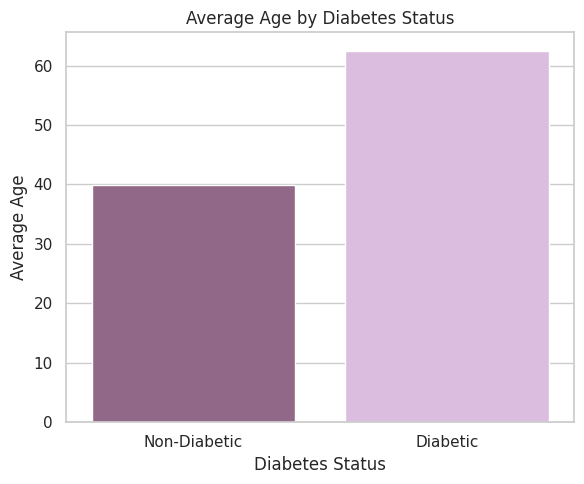

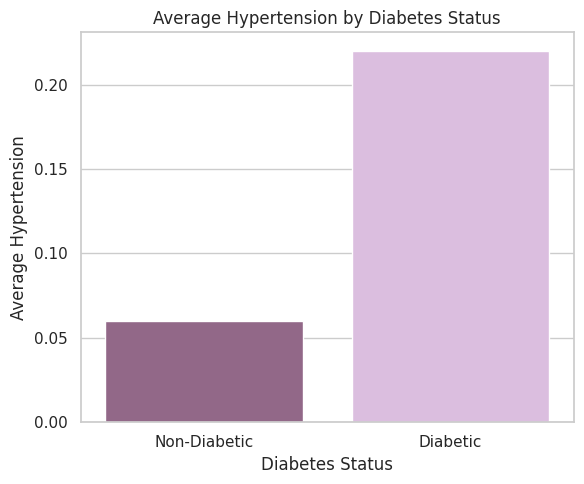

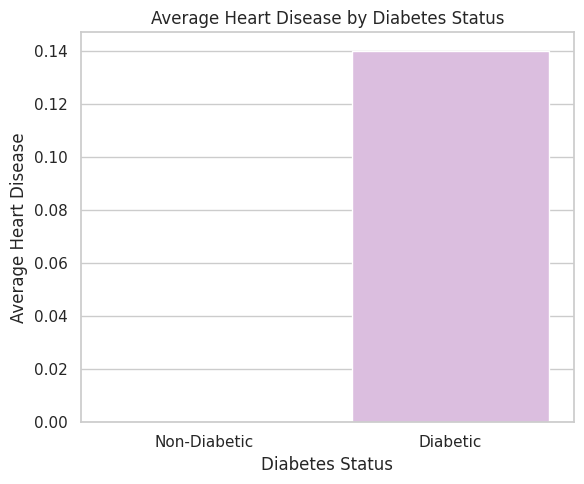

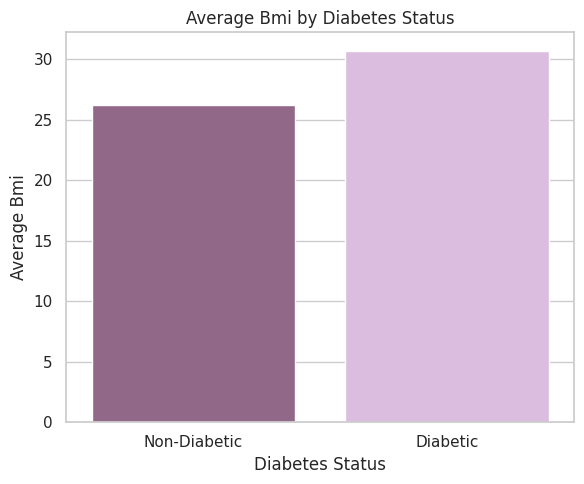

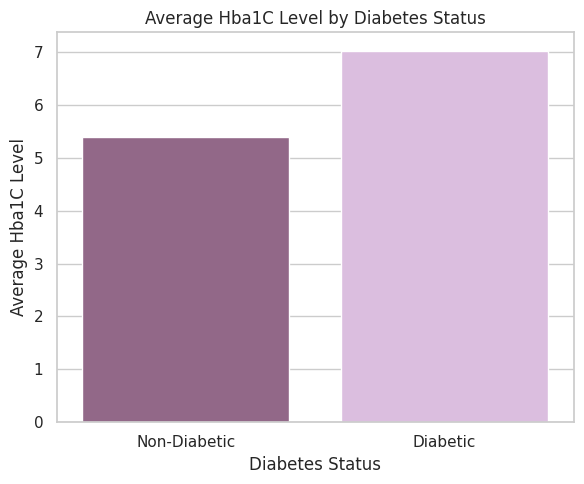

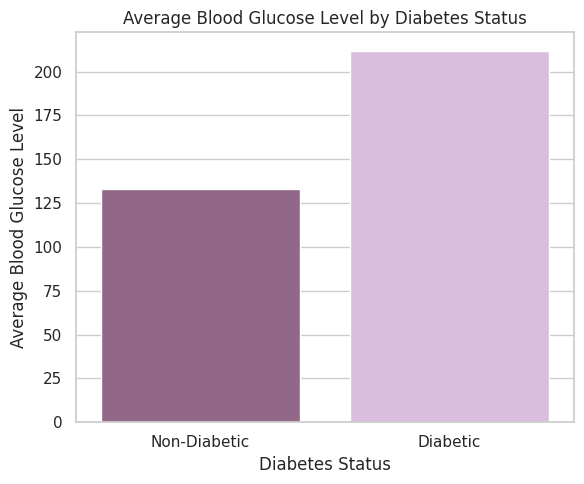

In [26]:
for var in variables:
    plt.figure(figsize=(6, 5))

    # Count the avg per group
    means = sample_combined_clean.groupby('diabetes')[var].mean()

    # Create bar plot
    sns.barplot(
        x = [group_labels[i] for i in means.index],
        y = means.values,
        hue = ['Non-Diabetic', 'Diabetic'],
        palette = [colors[i] for i in means.index],
        legend = False
    )

    plt.title(f"Average {var.replace('_', ' ').title()} by Diabetes Status")
    plt.ylabel(f"Average {var.replace('_', ' ').title()}")
    plt.xlabel("Diabetes Status")
    plt.tight_layout()
    plt.show()